In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [1]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

### Imports


In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install gudhi tqdm matplotlib scikit-learn scipy torch xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
from datasets.utils import create_multiple_circles
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm 
import gudhi as gd
from gudhi.representations import DiagramSelector, Landscape, PersistenceImage
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adamax
from utils import DenseRagged, PermopRagged, RaggedPersistenceModel 
from xgboost import XGBClassifier

### Definition of our Train/Test sets
Next we use helper functions to compute these point clouds.

In [5]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise, n_augment_per_sample= 0)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 100/100 [00:00<00:00, 127.72it/s]


Let's check some of these point clouds!

#### Plotting Point Clouds

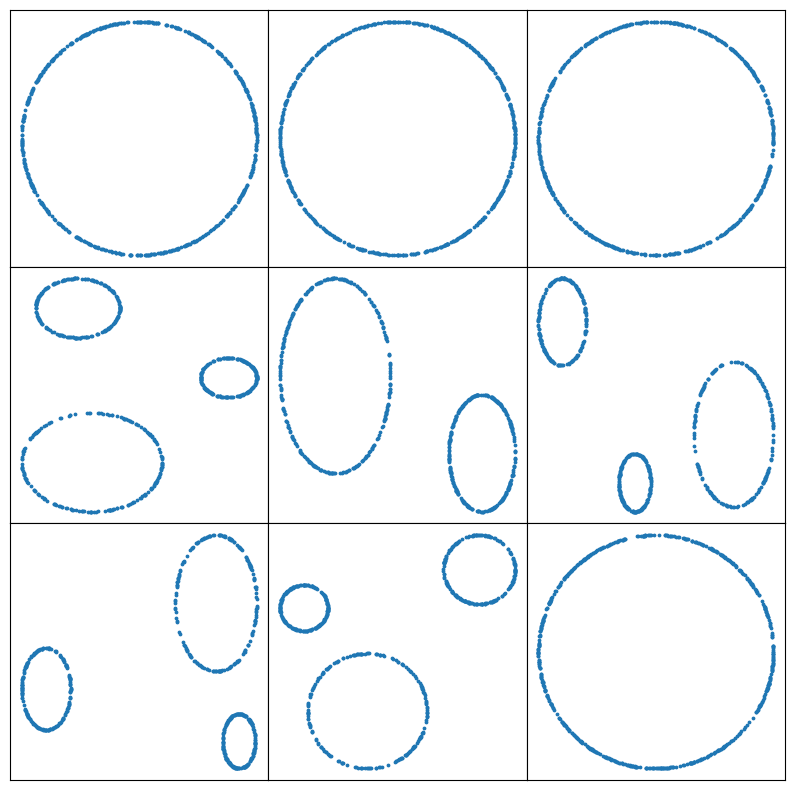

In [6]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

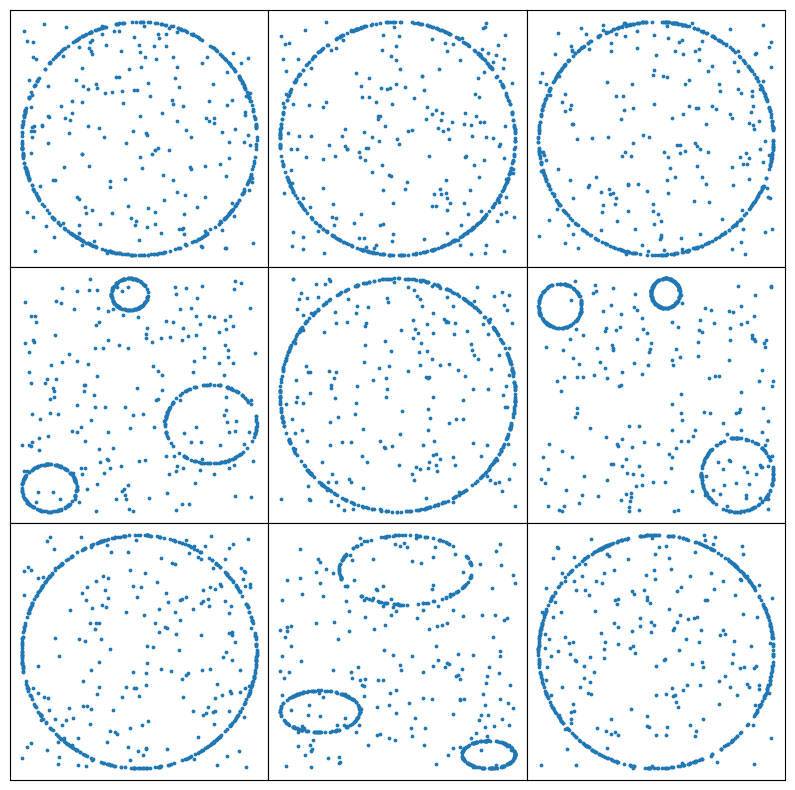

In [7]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

#### Cleaning Labels
As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [8]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

#### Distance Matrix


In [9]:
def distance_matrix(point_cloud):
    """
    Compute pairwise Euclidean distance matrix for a point cloud.
    Accepts numpy array, list-of-lists, or torch.Tensor of shape (N, d).
    Returns a numpy array of shape (N, N).
    """
    # rely on existing imports: np, torch
    if isinstance(point_cloud, __import__("torch").Tensor):
        point_cloud = point_cloud.cpu().numpy()
    pc = np.asarray(point_cloud, dtype=float)
    if pc.ndim == 1:
        pc = pc.reshape(-1, 1)
    diff = pc[:, None, :] - pc[None, :, :]
    return np.sqrt((diff ** 2).sum(axis=-1))

### Topology of point clouds

In order to train RipsNet, we need the correct topology on the train data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [10]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

#### Persistence diagrams
Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [11]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

100%|██████████| 900/900 [00:11<00:00, 81.43it/s]


In [12]:
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

  3%|▎         | 10/300 [00:00<00:07, 39.97it/s]

100%|██████████| 300/300 [00:04<00:00, 71.54it/s]


In [13]:
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:01<00:00, 171.14it/s]


#### Persistence Image & Persistence Landscape
RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [14]:
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates). 

In [15]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

We can now compute and normalize the vectorizations (this can help RipsNet training)!

In [16]:
if 'im_bnds' not in locals() or im_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    im_bnds = [x_min, x_max, y_min, y_max]

PI_params = {
    'bandwidth': sigma,
    'weight': lambda x: 10 * np.tanh(x[1]),
    'resolution': [50, 50],
    'im_range': im_bnds
}

PI = PersistenceImage(**PI_params)
PI.fit(pds_train)  

PI_train = PI.transform(pds_train)
clean_PI_test = PI.transform(clean_pds_test)
noisy_PI_test = PI.transform(noisy_pds_test)

MPI = np.max(PI_train)
if MPI == 0 or np.isnan(MPI):
    raise ValueError("MPI (max value) is zero or NaN; check persistence diagrams.")
else:
    PI_train /= MPI
    clean_PI_test /= MPI
    noisy_PI_test /= MPI

PI_train = torch.tensor(PI_train, dtype=torch.float32)
clean_PI_test = torch.tensor(clean_PI_test, dtype=torch.float32)
noisy_PI_test = torch.tensor(noisy_PI_test, dtype=torch.float32)

print(f"PI_train shape: {PI_train.shape}")
print(f"clean_PI_test shape: {clean_PI_test.shape}")
print(f"noisy_PI_test shape: {noisy_PI_test.shape}")
print(f"Max pixel intensity (MPI): {MPI:.5f}")


PI_train shape: torch.Size([900, 2500])
clean_PI_test shape: torch.Size([300, 2500])
noisy_PI_test shape: torch.Size([300, 2500])
Max pixel intensity (MPI): 0.13541


In [17]:

if 'sp_bnds' not in locals() or sp_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 1])
    sp_bnds = [x_min, x_max]


PL_params = {
    'num_landscapes': 5,
    'resolution': 300,
    'sample_range': sp_bnds
}

PL = Landscape(**PL_params)
PL.fit(pds_train) 

PL_train = PL.transform(pds_train)
clean_PL_test = PL.transform(clean_pds_test)
noisy_PL_test = PL.transform(noisy_pds_test)

MPL = np.max(PL_train)
if MPL == 0 or np.isnan(MPL):
    raise ValueError("MPL (max landscape value) is zero or NaN; check your persistence diagrams.")
else:
    PL_train /= MPL
    clean_PL_test /= MPL
    noisy_PL_test /= MPL

PL_train = torch.tensor(PL_train, dtype=torch.float32)
clean_PL_test = torch.tensor(clean_PL_test, dtype=torch.float32)
noisy_PL_test = torch.tensor(noisy_PL_test, dtype=torch.float32)

print(f"PL_train shape: {PL_train.shape}")
print(f"clean_PL_test shape: {clean_PL_test.shape}")
print(f"noisy_PL_test shape: {noisy_PL_test.shape}")
print(f"Max landscape value (MPL): {MPL:.5f}")


PL_train shape: torch.Size([900, 1500])
clean_PL_test shape: torch.Size([300, 1500])
noisy_PL_test shape: torch.Size([300, 1500])
Max landscape value (MPL): 17.54756


### Time to Train !
It is finally time to train RipsNet! We will do it with Pytorch, and custom DeepSet operations.

First, let's convert the point clouds into ragged tensors.

In [18]:
tf_data_train = [torch.tensor(pc, dtype=torch.float32) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in clean_data_test]
tf_noisy_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in noisy_data_test]

Next, we define our RipsNet architecture for learning persistence images, a sequence of fully-connected DeepSet layers, with ReLu activations, Adamax optimizer, and early stopping.

In [19]:
output_dim = PI_train.shape[1] 
model_PI = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss()

Time to learn!

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    """
    Train a ragged-input model. Returns (best_model, history, best_model_state).
    """
    model = model.to(device)
    patience = 200
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 10000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    # helper to move inputs to device
    def to_device_list(lst):
        out = []
        for x in lst:
            if isinstance(x, torch.Tensor):
                out.append(x.to(device).float())
            else:
                out.append(torch.tensor(x, dtype=torch.float32, device=device))
        return out

    train_inputs = to_device_list(train_inputs)
    val_inputs = to_device_list(val_inputs)

    if isinstance(train_targets, torch.Tensor):
        train_targets = train_targets.to(device).float()
    else:
        train_targets = torch.tensor(train_targets, dtype=torch.float32, device=device)

    if isinstance(val_targets, torch.Tensor):
        val_targets = val_targets.to(device).float()
    else:
        val_targets = torch.tensor(val_targets, dtype=torch.float32, device=device)

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(len(train_inputs), device=device)
        epoch_loss = 0.0
        for i in range(0, len(train_inputs), batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]
            batch_inputs = [train_inputs[int(idx)].to(device) for idx in indices]
            batch_targets = train_targets[indices]

            outputs = model(batch_inputs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[0]
            if not isinstance(outputs, torch.Tensor):
                outputs = torch.tensor(outputs, dtype=batch_targets.dtype, device=device)
            else:
                outputs = outputs.to(device).type(batch_targets.dtype)

            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_inputs)

        epoch_loss /= len(train_inputs)
        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            if isinstance(val_outputs, (list, tuple)):
                val_outputs = val_outputs[0]
            val_outputs = val_outputs.to(device).type(val_targets.dtype)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-8:
            best_val_loss = val_loss
            patience_counter = 0
            # save best model (on CPU to avoid holding GPU memory)
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # if we saved a best state, load it back into the model on the current device
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state 

In [21]:
# Training RipsNet to predict Persistence Images (original training loop)
model = model_PI
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PI.parameters(), lr=5e-4)
train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PI_test, dtype=torch.float32).to(device)

/tmp/ipykernel_2028/1374235358.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_2028/1374235358.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2028/1374235358.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_2028/1374235358.py:8: UserWarn

In [22]:

# Train model_PI using the helper function defined earlier
# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PI, history_PI, best_model_state = train_model(
    model_PI, optimizer, criterion,
    train_inputs, train_targets,
    val_inputs, val_targets,
    epochs=num_epochs, batch_size=32
)

best_val_loss = min(history_PI['val_loss']) if history_PI.get('val_loss') else float('inf')
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")

Epoch 1/10000, Train Loss: 0.199855, Val Loss: 0.177551
Epoch 2/10000, Train Loss: 0.143078, Val Loss: 0.092971
Epoch 3/10000, Train Loss: 0.048977, Val Loss: 0.016323
Epoch 4/10000, Train Loss: 0.009961, Val Loss: 0.006798
Epoch 5/10000, Train Loss: 0.005814, Val Loss: 0.005384
Epoch 6/10000, Train Loss: 0.004944, Val Loss: 0.004887
Epoch 7/10000, Train Loss: 0.004570, Val Loss: 0.004633
Epoch 8/10000, Train Loss: 0.004367, Val Loss: 0.004485
Epoch 9/10000, Train Loss: 0.004244, Val Loss: 0.004392
Epoch 10/10000, Train Loss: 0.004162, Val Loss: 0.004331
Epoch 11/10000, Train Loss: 0.004112, Val Loss: 0.004288
Epoch 12/10000, Train Loss: 0.004070, Val Loss: 0.004258
Epoch 13/10000, Train Loss: 0.004043, Val Loss: 0.004235
Epoch 14/10000, Train Loss: 0.004024, Val Loss: 0.004218
Epoch 15/10000, Train Loss: 0.004006, Val Loss: 0.004206
Epoch 16/10000, Train Loss: 0.003993, Val Loss: 0.004197
Epoch 17/10000, Train Loss: 0.003988, Val Loss: 0.004188
Epoch 18/10000, Train Loss: 0.003977, Va

Learning is done! The advantage of RipsNet is that we can now use it to predict persistence images directly from point clouds in the blink of an eye!Let's see how accurate the predictions of RipsNet really are, at least on the train set.

In [23]:
model_PI.eval()

with torch.no_grad():
    # ensure inputs have the same dtype as the model parameters (float32)
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PI_prediction = model_PI(train_inputs).cpu().numpy()
    clean_PI_prediction = model_PI(clean_inputs).cpu().numpy()
    noisy_PI_prediction = model_PI(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PI_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PI_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PI_prediction.shape}")


/tmp/ipykernel_2028/2216463292.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_2028/2216463292.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_2028/2216463292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 2500)
clean_PI_prediction shape: (300, 2500)
noisy_PI_prediction shape: (300, 2500)


Pretty good actually! Let's look at the test set now.

Saved noisy_gudhi_pc.png
Saved noisy_gudhi_pi.png


/tmp/ipykernel_2028/615910270.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(noisy_PI_test[idx])


Saved noisy_ripsnet_pi.png


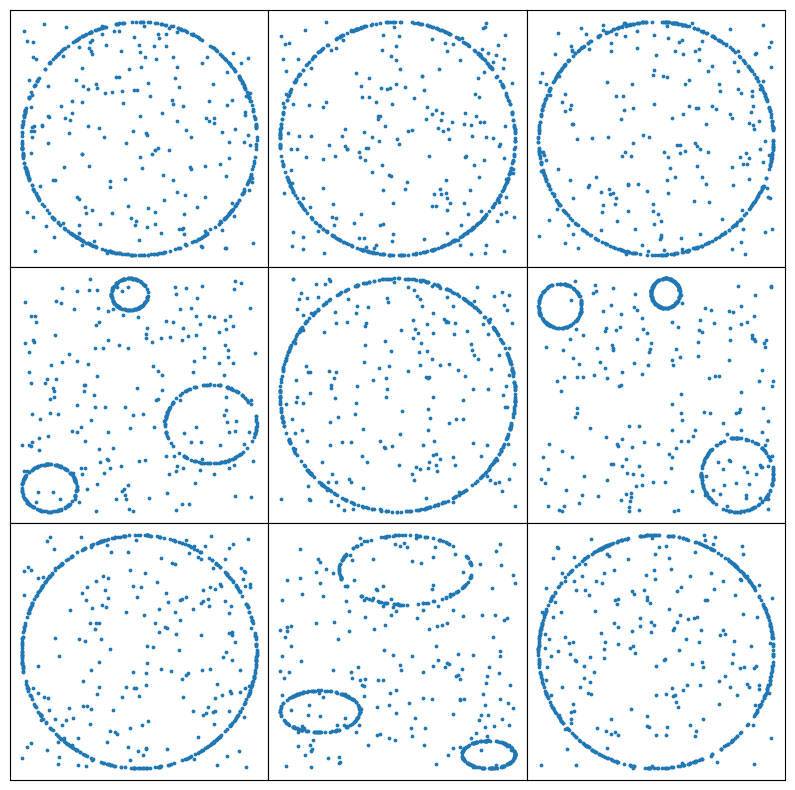

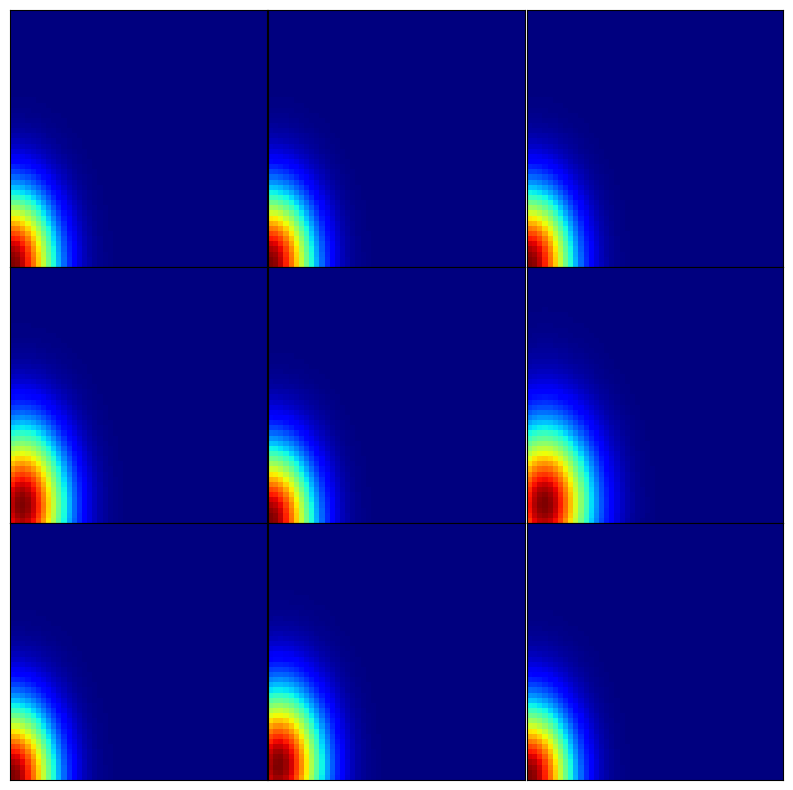

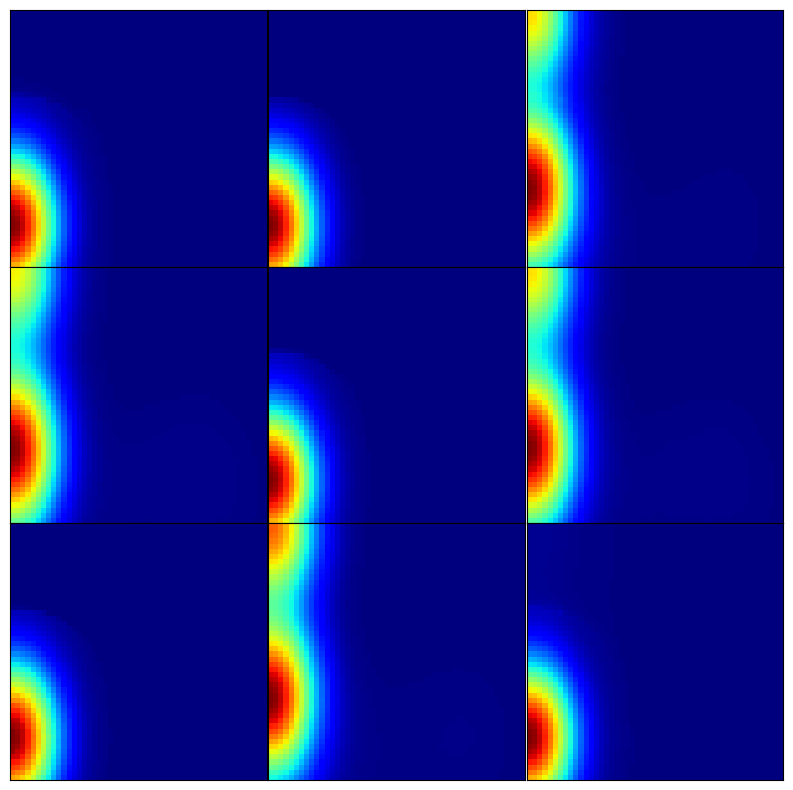

In [24]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PI_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pi.png", bbox_inches="tight")
print("Saved noisy_gudhi_pi.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PI_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0) 
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pi.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pi.png")


Yep, even though Gudhi now produces bad images because of the ambiant noise, RipsNet predictions still look rather good. Another way to quantify this is to see the difference between classifiers predicting the number of circles that are trained either from Gudhi or from RipsNet predictions. Let's first see how an XGBoost model performs when using Gudhi descriptors.

In [25]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [09:55:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 1.0
Accuracy on noisy test set = 0.3333333333333333


Well, the classifier definitely does well on clean data but struggles on noisy data. Let's see how another classifier trained on RipsNet descriptors now performs.

In [27]:
# ensure labels match the augmented training set size
# `le` was fitted earlier; label_train was augmented to match train inputs
label_classif_train_aug = le.transform(label_train)

model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train_aug)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [09:55:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [28]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.73
Accuracy on noisy test set = 0.7433333333333333


Well, even though the accuracy is slightly worse on clean data, it does remarkably well when noise is added! This illustrates the robustness of RipsNet-based topological descriptors.

Now, let's play the same game with persistence landscapes, using the same architecture (except for the dimension of the final layer of course). In the three following cells, we define RipsNet, train it on landscapes, and use it to predict persistence landscapes from the data.

In [29]:
output_dim = PL_train.shape[1] 
model_PL = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PL.parameters(), lr=5e-4)
criterion = nn.MSELoss()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_PL = model_PL.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PL.parameters(), lr=5e-4)

patience = 200
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10000

# prepare data once (move to device)
train_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_data_train]
train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)

val_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)

history = {'train_loss': [], 'val_loss': []}
best_model_state = {k: v.cpu() for k, v in model_PL.state_dict().items()}

for epoch in range(num_epochs):
    model_PL.train()
    optimizer.zero_grad()

    outputs = model_PL(train_inputs)
    if isinstance(outputs, (list, tuple)):
        outputs = outputs[0]
    if outputs is None:
        raise RuntimeError("model_PL returned None")
    if not isinstance(outputs, torch.Tensor):
        outputs = torch.tensor(outputs, dtype=train_targets.dtype, device=train_targets.device)
    else:
        outputs = outputs.to(train_targets.device).type(train_targets.dtype)

    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    model_PL.eval()
    with torch.no_grad():
        val_outputs = model_PL(val_inputs)
        if isinstance(val_outputs, (list, tuple)):
            val_outputs = val_outputs[0]
        val_outputs = val_outputs.to(val_targets.device).type(val_targets.dtype)
        val_loss = criterion(val_outputs, val_targets)

    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if val_loss.item() < best_val_loss - 1e-5:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # save on CPU to avoid GPU memory hold
        best_model_state = {k: v.cpu().clone() for k, v in model_PL.state_dict().items()}
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {loss.item():.6f}, Val loss: {val_loss.item():.6f}")

# load best weights back to device
model_PL.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipykernel_2028/3856649353.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)
/tmp/ipykernel_2028/3856649353.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)


Epoch 50/10000 - Train loss: 0.151571, Val loss: 0.148385


Epoch 100/10000 - Train loss: 0.016092, Val loss: 0.015628
Epoch 150/10000 - Train loss: 0.010134, Val loss: 0.010104
Epoch 200/10000 - Train loss: 0.009446, Val loss: 0.009431
Epoch 250/10000 - Train loss: 0.009199, Val loss: 0.009187
Epoch 300/10000 - Train loss: 0.009076, Val loss: 0.009062
Epoch 350/10000 - Train loss: 0.008981, Val loss: 0.008961
Epoch 400/10000 - Train loss: 0.008872, Val loss: 0.008842
Epoch 450/10000 - Train loss: 0.008712, Val loss: 0.008665
Epoch 500/10000 - Train loss: 0.008445, Val loss: 0.008368
Epoch 550/10000 - Train loss: 0.007973, Val loss: 0.007843
Epoch 600/10000 - Train loss: 0.007205, Val loss: 0.006990
Epoch 650/10000 - Train loss: 0.006177, Val loss: 0.005867
Epoch 700/10000 - Train loss: 0.005159, Val loss: 0.004777
Epoch 750/10000 - Train loss: 0.004432, Val loss: 0.004042
Epoch 800/10000 - Train loss: 0.003912, Val loss: 0.003566
Epoch 850/10000 - Train loss: 0.003457, Val loss: 0.003178
Epoch 900/10000 - Train loss: 0.003030, Val loss: 0.0028

In [31]:
model_PL.eval()

with torch.no_grad():
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PL_prediction = model_PL(train_inputs).cpu().numpy()
    clean_PL_prediction = model_PL(clean_inputs).cpu().numpy()
    noisy_PL_prediction = model_PL(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PL_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PL_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PL_prediction.shape}")


Predictions computed:
train_PI_prediction shape: (900, 1500)
clean_PI_prediction shape: (300, 1500)
noisy_PI_prediction shape: (300, 1500)


/tmp/ipykernel_2028/2552692517.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_2028/2552692517.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_2028/2552692517.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Let's see how good RipsNet is for landscapes now.

Saved clean_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500


/tmp/ipykernel_2028/734158903.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(clean_PL_test[idx])


Saved clean_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved clean_ripsnet_pl.png


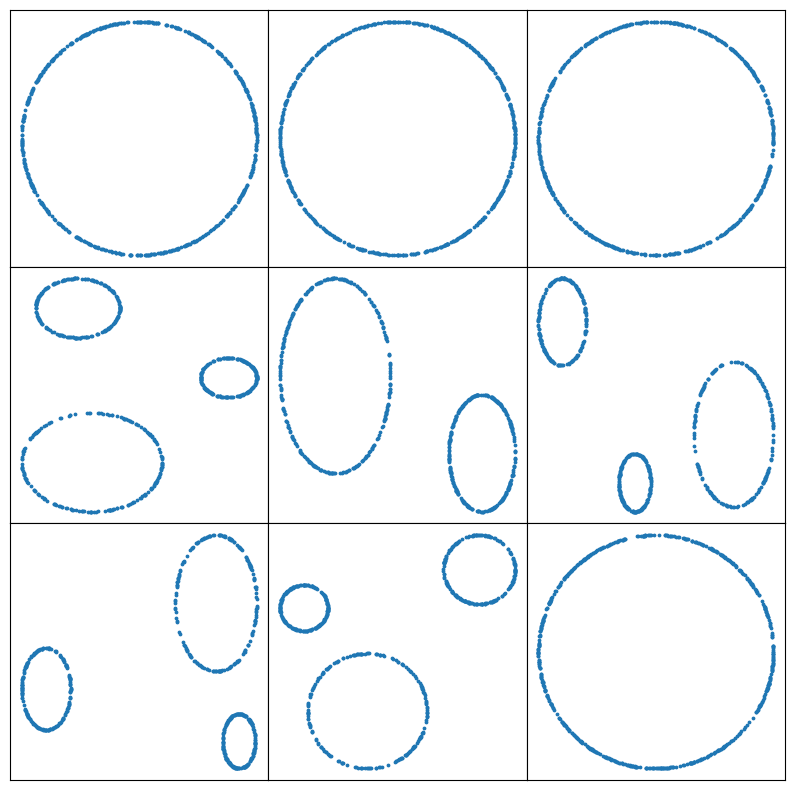

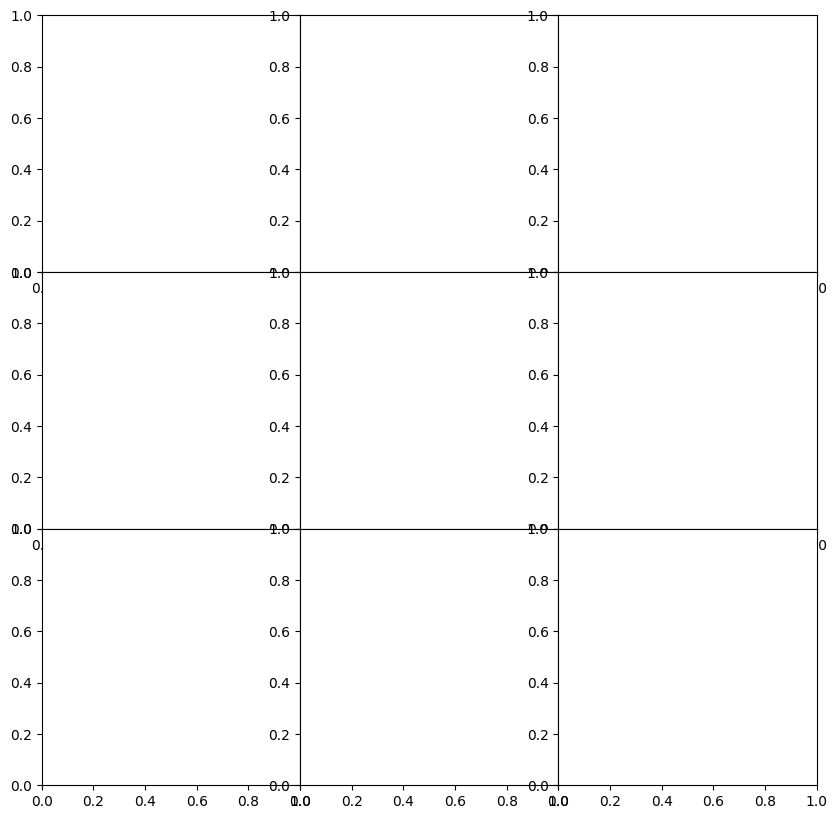

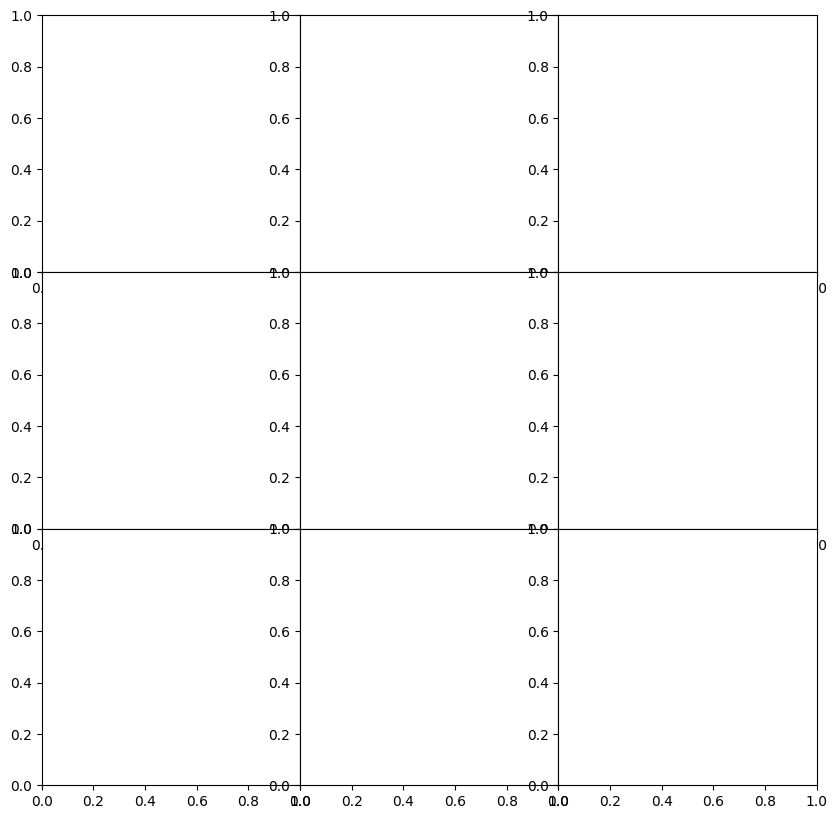

In [32]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_clean_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')
print("Saved clean_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(clean_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pl.png', bbox_inches='tight')
print("Saved clean_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(clean_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0)  
        ax.imshow(pred, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_ripsnet_pl.png', bbox_inches='tight')
print("Saved clean_ripsnet_pl.png")


Saved noisy_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500


/tmp/ipykernel_2028/3525282999.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(noisy_PL_test[idx])


Saved noisy_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved noisy_ripsnet_pl.png


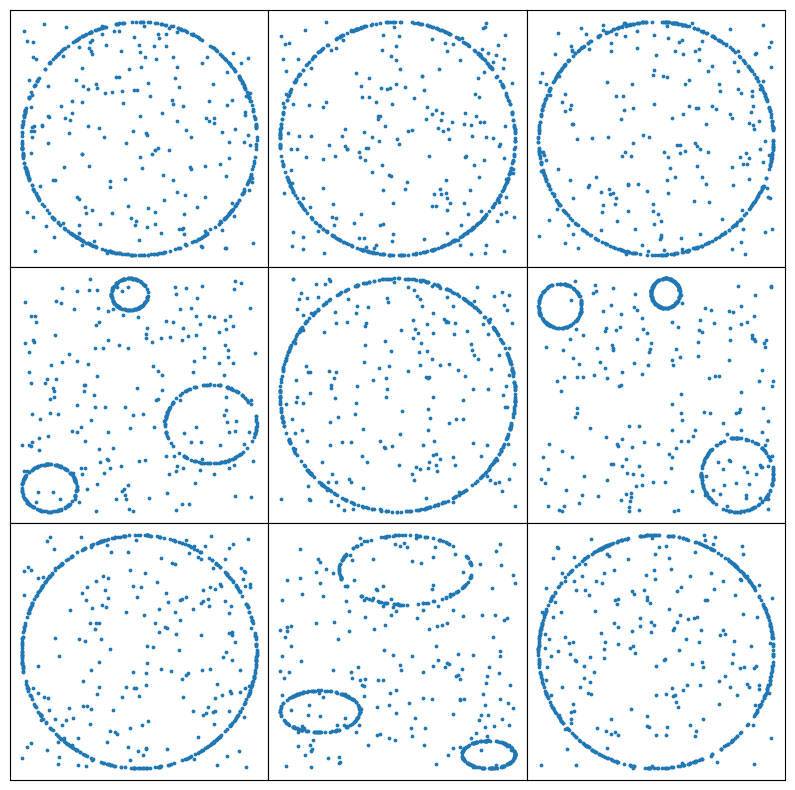

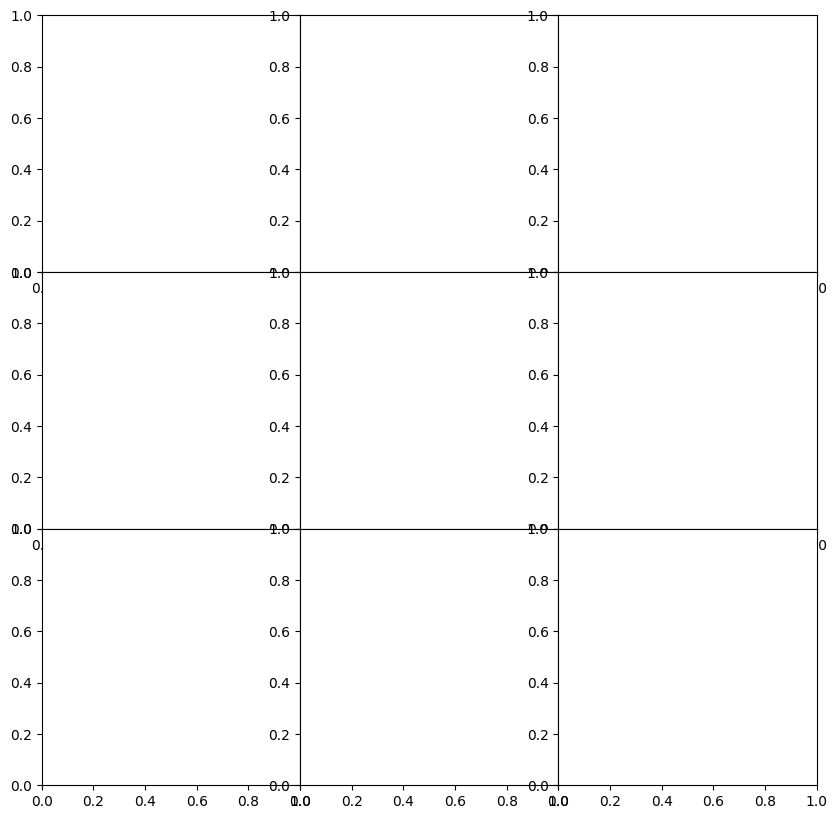

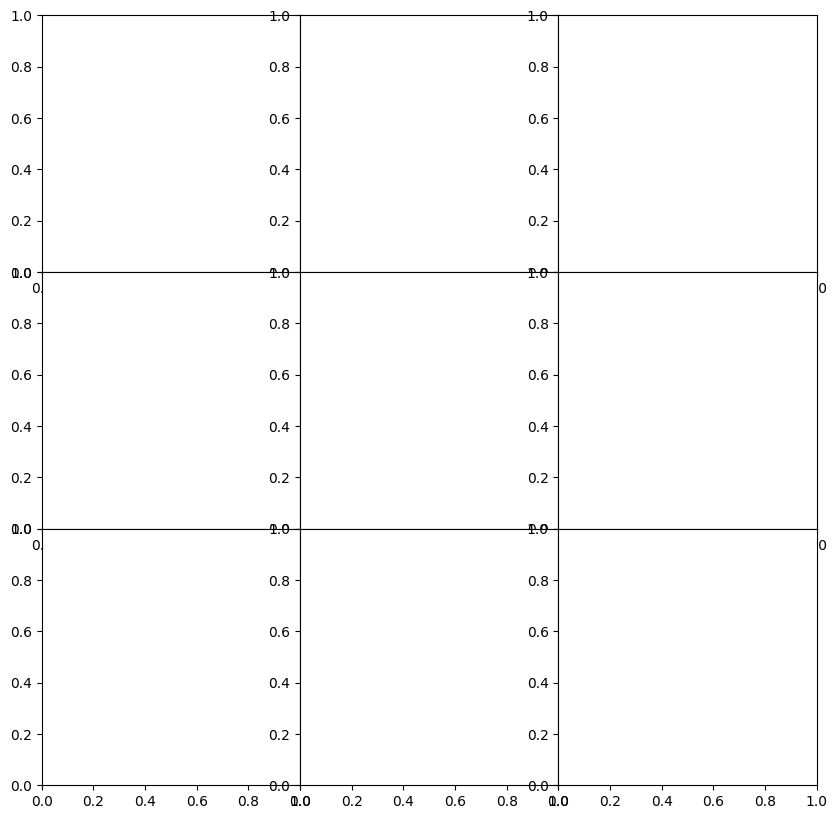

In [33]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pl.png", bbox_inches="tight")
print("Saved noisy_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0) 
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pl.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pl.png")


As before, we end by training XGBoost classifier on both Gudhi and RipsNet generated landscapes.

In [34]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PL_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PL_test,  clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PL_test,  noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:09:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [35]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 1.0
Accuracy on noisy test set = 0.38


In [36]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:09:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [37]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.74
Accuracy on noisy test set = 0.6933333333333334


The difference is less clear than for persistence images, but present nonetheless! Again, RipsNet exhibits better  robustness properties than Gudhi on noise data, while being faster and almost as good on clean data.

In [38]:
### Persistence Image (PI) — model structure (summary)

### Persistence Image (PI) — model structure (summary)

- Input: a persistence diagram (set of (birth, death) pairs). Preprocessing commonly transforms to (birth, persistence) = (b, d - b).
- Kernelization: each point is embedded with a Gaussian (bandwidth σ). Weighting can be applied per point (e.g., weight(b, p) = 10 * tanh(p)) to emphasize high-persistence features.
- Rasterization: the continuous weighted sum of Gaussians is sampled on a fixed D grid (resolution WxH) over a chosen image range (xmin,xmax,pmin,pmax).
- Normalization: images are typically normalized by the maximum pixel intensity (MPI) computed on the training set (or per-split) to keep values stable for learning.
- Output: flattened image vector (W·H) or tensor (W,H) used as regression target for the network.
- Hyperparameters to tune: σ (bandwidth), weighting function, resolution, image range, normalization strategy.
- Practical notes: compute σ from pairwise distances (e.g., 20% quantile of non-zero pairwise birth-persistence distances); ensure im_range covers all train diagrams to avoid cropping; guard against MPI==0 or NaN.

---

### RaggedPersistenceModel — design and behavior

- Purpose: map ragged point-cloud inputs (variable-number-of-points Ni, each point in R^2) to fixed-size topological descriptors (PI or landscape vectors).
- Overall pattern: per-point embedding φ : R^2 → R^k (shared MLP) → permutation-invariant aggregation (sum or mean) → global map ρ : R^k → R^D (MLP + final linear) producing output_dim = D.
- Per-point map (φ):
    - Shared MLP applied independently to each 2D point.
    - ReLU activations between linear layers.
    - Produces a per-point feature vector of size phi_dim.
- Aggregation:
    - Options: sum or mean (mean implemented as sum / max(1,length) to avoid division by zero).
    - Implemented with masking when using padding: padded points are zeroed out before aggregation.
- Global map (ρ):
    - One or more MLP layers ending with a linear output to match output_dim.
    - ReLU activations in hidden layers; final layer linear to predict continuous descriptor values.
- Ragged-input handling:
    - Accepts a list/tuple of tensors [Ni×2]. For batching, inputs are padded to the same length and a mask computed from original lengths.
    - Mask zeros out padded rows so they don't affect aggregation.
    - If empty batch, returns an empty tensor with the correct output width.
- Device & dtype:
    - Model parameters determine device; inputs should be moved to that device and cast to float32 before forward.
- Robustness:
    - Clamp aggregating denominator to ≥1 to avoid NaN for empty point clouds.
    - Return consistent output shapes: (B, output_dim) where B is batch size (list length).
- Training recipe (typical):
    - Loss: MSE for regression against PI/landscape targets.
    - Optimizer: Adamax (or Adam) with small LR (e.g., 5e-4).
    - Early stopping on validation loss, patience tuned (e.g., 200).
    - Mini-batch training implemented by sampling subsets from the list of ragged inputs, padding each batch, and computing targets as tensors aligned with batch indices.
- Practical checks:
    - Ensure phi/rho layer sizes produce the desired output dimension.
    - Verify outputs are tensors (not None/lists) and dtype/device match targets before computing loss.
    - Save best weights on CPU to avoid holding GPU memory and reload after training.

---

These descriptions match the PI preprocessing + rasterization pipeline and the DeepSet-style RaggedPersistenceModel used to regress from point clouds to fixed-size topological descriptors.
- Rasterization: the continuous weighted sum of Gaussians is sampled on a fixed 2D grid (resolution WxH) over a chosen image range (xmin,xmax,pmin,pmax).
- Normalization: images are typically normalized by the maximum pixel intensity (MPI) computed on the training set (or per-split) to keep values stable for learning.
- Output: flattened image vector (W·H) or tensor (W,H) used as regression target for the network.
- Hyperparameters to tune: σ (bandwidth), weighting function, resolution, image range, normalization strategy.
- Practical notes: compute σ from pairwise distances (e.g., 20% quantile of non-zero pairwise birth-persistence distances); ensure im_range covers all train diagrams to avoid cropping; guard against MPI==0 or NaN.

---

### RaggedPersistenceModel — design and behavior

- Purpose: map ragged point-cloud inputs (variable-number-of-points Ni, each point in R^2) to fixed-size topological descriptors (PI or landscape vectors).
- Overall pattern: per-point embedding φ : R^2 → R^k (shared MLP) → permutation-invariant aggregation (sum or mean) → global map ρ : R^k → R^D (MLP + final linear) producing output_dim = D.
- Per-point map (φ):
    - Shared MLP applied independently to each 2D point.
    - ReLU activations between linear layers.
    - Produces a per-point feature vector of size phi_dim.
- Aggregation:
    - Options: sum or mean (mean implemented as sum / max(1,length) to avoid division by zero).
    - Implemented with masking when using padding: padded points are zeroed out before aggregation.
- Global map (ρ):
    - One or more MLP layers ending with a linear output to match output_dim.
    - ReLU activations in hidden layers; final layer linear to predict continuous descriptor values.
- Ragged-input handling:
    - Accepts a list/tuple of tensors [Ni×2]. For batching, inputs are padded to the same length and a mask computed from original lengths.
    - Mask zeros out padded rows so they don't affect aggregation.
    - If empty batch, returns an empty tensor with the correct output width.
- Device & dtype:
    - Model parameters determine device; inputs should be moved to that device and cast to float32 before forward.
- Robustness:
    - Clamp aggregating denominator to ≥1 to avoid NaN for empty point clouds.
    - Return consistent output shapes: (B, output_dim) where B is batch size (list length).
- Training recipe (typical):
    - Loss: MSE for regression against PI/landscape targets.
    - Optimizer: Adamax (or Adam) with small LR (e.g., 5e-4).
    - Early stopping on validation loss, patience tuned (e.g., 200).
    - Mini-batch training implemented by sampling subsets from the list of ragged inputs, padding each batch, and computing targets as tensors aligned with batch indices.
- Practical checks:
    - Ensure phi/rho layer sizes produce the desired output dimension.
    - Verify outputs are tensors (not None/lists) and dtype/device match targets before computing loss.
    - Save best weights on CPU to avoid holding GPU memory and reload after training.

---

These descriptions match the PI preprocessing + rasterization pipeline and the DeepSet-style RaggedPersistenceModel used to regress from point clouds to fixed-size topological descriptors.


SyntaxError: invalid character '→' (U+2192) (1503713934.py, line 18)

In [39]:
import torch
import torch.nn as nn
from typing import List

class DistanceMatrixRaggedModel(nn.Module):
    def __init__(self, output_dim, num_points=None, phi_dim=128, rho_hidden=(256,128)):
        """
        output_dim: final descriptor size (e.g., PI_train.shape[1])
        num_points: expected number of points (row length). If None, model infers size at first forward.
        phi_dim: per-row embedding size
        rho_hidden: sizes of hidden layers for global map
        """
        super().__init__()
        self.num_points = num_points
        inp = num_points if num_points is not None else 0
        self._phi_layers = None
        self.phi_dim = phi_dim
        self._build_phi(inp)
        layers = []
        prev = phi_dim
        for h in rho_hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.rho = nn.Sequential(*layers)

    def _build_phi(self, inp):
        if inp <= 0:
            self._phi_layers = None
            return
        hidden = max(64, self.phi_dim)
        self._phi_layers = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.phi_dim),
            nn.ReLU()
        )

    def forward(self, batch: List[torch.Tensor]):
        """
        batch: list of (Ni x Ni) distance matrices (torch.Tensor)
        returns: (B, output_dim)
        """
        if len(batch) == 0:
            return torch.empty(0, self.rho[-1].out_features, device=next(self.parameters()).device)

        sizes = [m.shape[0] for m in batch]
        max_n = max(sizes)
        device = next(self.parameters()).device

        if self._phi_layers is None or (self.num_points and self.num_points != max_n):
            self._build_phi(max_n)
            self.num_points = max_n
            self._phi_layers = self._phi_layers.to(device)

        B = len(batch)
        mats = torch.zeros((B, max_n, max_n), dtype=torch.float32, device=device)
        row_mask = torch.zeros((B, max_n), dtype=torch.bool, device=device)
        for i, m in enumerate(batch):
            n = m.shape[0]
            mats[i, :n, :n] = m.to(device).float()
            row_mask[i, :n] = 1

        rows = mats.reshape(B * max_n, max_n)
        phi_out = self._phi_layers(rows)
        phi_out = phi_out.reshape(B, max_n, -1)

        lengths = row_mask.sum(dim=1).clamp(min=1).unsqueeze(-1).float()
        summed = (phi_out * row_mask.unsqueeze(-1).float()).sum(dim=1)
        aggregated = summed / lengths

        out = self.rho(aggregated)
        return out
